# Look at the distibution of jet subjects over the time. 
## Need: question_reducer_jet_or_not.csv
This jupyter notebook plots the results of the Jet or No question, the Jet distribution over the subjects over the years the data was taken  
We look at the amount of subjects that are containing jets. A large portion of our subjects do not contain jets, thus the first workflow gives us higher   
temporal constaint on the occurence of jets than the HEK starting data gave us.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from aggregation import QuestionResult, MetaFile
%matplotlib inline

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


Get the results from the first workflow. Get the agreement, masks of which subjects do or do not contain a jet, the most likely answer. 
Also get properties of the subjects from the meta data: observation time first image in the subject, SOL/HEK reported event, filename in Zooniverse and final time of last image in last subject. 

In [2]:
# initiate the filled data set as a class
data_T0 = QuestionResult('reductions/question_reducer_jet_or_not.csv')

# Calculate the agreement
agreement_T0, jet_mask_T0, non_jet_mask_T0, Ans_T0 = data_T0.Agr_mask(data_T0.data)
subjects = data_T0.subjects

metafile = MetaFile('../Meta_data_subjects.json')
obs_time_T0 = metafile.get_subjectkeyvalue_by_list(subjects, 'startDate')

Show the data received from the first workflow. How many subjects are containing jets over the years data

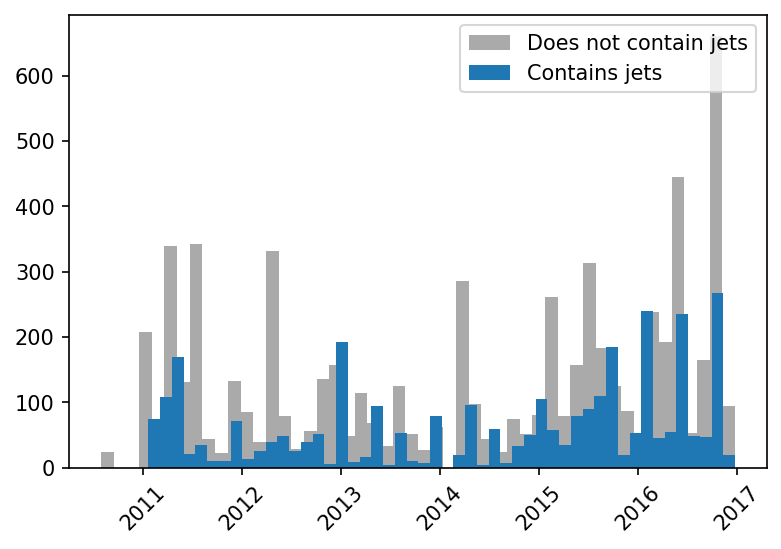

In [3]:
plt.figure(dpi=150, facecolor='white')
plt.hist(obs_time_T0[non_jet_mask_T0], bins=50, color="#aaa", label="Does not contain jets")
plt.hist(obs_time_T0[jet_mask_T0], bins=50, label="Contains jets")
plt.xticks(rotation=45)

plt.legend(loc='upper right')

plt.show()